## Tracking and nowcasting of lightning flash-cells using data from the LINET network

Analysis of lightning strike density distribution, clustering, cell-tracking, and nowcasting using open-source tools (Python).

**Author**: Petar Sarajcev, PhD (petar.sarajcev@fesb.hr)
 
University of Split, FESB, Department of Power Engineering,
R. Boskovica 32, HR-21000 Split, Croatia, EU.

A dataset of lightning information for a particular region of cca 400 km2 of Croatian mainland, for a calendar year of 2014, has been obtained from the German company **nowcast GmbH** https://www.nowcast.de/en.html (which operates the European LINET lightning detection network). This dataset is proprietary and has been obtained for the research purposes only. It can't be shared with third parties due to licensing restrictions. Only results of the analysis on the dataset will be presented hereafter.
 
The dataset is in plain ASCII format and contains following lightning-related information:
- date and time (down to milisecond resolution) of lightning strike,
- geographic location (longitude and latitude) of lightning strike,
- type of lightning strike (cloud-to-ground or cloud-to-cloud), indicated with a number 1 or 2,
- amplitude of lightning strike in kilo-amperes (positive or negative number, indicating polarity as well).
 
It ought to be stated that the dataset does not discriminate between the first and subsequent strokes within the lightning flash.

In [1]:
from __future__ import print_function

In [2]:
import warnings

# Disable warnings emitted by warnings.warn calls from different packages
# matplotlib can show a warning with tight_layout that can be safely ignored
warnings.filterwarnings('ignore')

In [3]:
# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# Scikit-learn
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise, silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
# Scipy
from scipy import interpolate
from scipy import spatial
from scipy import stats
from scipy.cluster import hierarchy
# Shapely
from shapely import geometry
from shapely import affinity
# Statsmodels
import statsmodels.api as sm
# Folium maps
import folium
# Others
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import pickle
from math import modf

In [4]:
# Seaborn style (figures)
sns.set(context='notebook', style='whitegrid', font_scale=1.25)
sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})

# Folium
folium.initialize_notebook()

# Inline figures (matplotlib)
%matplotlib inline

### Import LINET data

In [5]:
# Read lightning data from external file (not csv)
filename = 'lightning_data_20140101_20141231.txt'
date_li = []
time_li = []
lon_li = []
lat_li = []
type_li = []
ampl_li = []
with open(filename, 'r') as fp:
    next(fp)  # skip the first line (column names)
    for line in fp:
        d, t, lon, lat, ty, am = line.split()
        date_li.append(d)
        time_li.append(t)
        lon_li.append(float(lon))
        lat_li.append(float(lat))
        type_li.append(int(ty))
        ampl_li.append(float(am))
# Convert date and time to datetime objects
date_time = []
for d, t in zip(date_li, time_li):
    y, m, d = d.split('-')
    hr, mnt, sec = t.split(':')
    msec, sec = modf(float(sec))
    msec *= 1e6  # datetime needs microseconds
    date_time.append(dt.datetime(int(y), int(m), int(d),
                                 int(hr), int(mnt), int(sec), int(msec)))

# Create pandas dataframe
# Type 1 refers to a cloud-to-ground stroke, type 2 to an in-cloud stroke
li = pd.DataFrame({'lat': lat_li, 'lon': lon_li, 'type': type_li, 'ampl': ampl_li}, index=date_time)
print(li.head())

                             ampl     lat     lon  type
2014-01-19 18:44:05.767000  -23.3  43.696  15.901     1
2014-01-19 18:44:06.176000    5.9  43.702  15.938     2
2014-01-19 18:51:20.268000 -116.6  43.743  15.894     1
2014-01-19 18:53:58.817000    9.9  43.778  15.901     1
2014-01-19 23:13:53.932999   -5.1  43.674  15.918     1


In [6]:
# Adding column with lightning polarity
# -1 for negative lightning
#  1 for positive lightning
li['pol'] = np.array([1 if x > 0 else -1 for x in li['ampl']])
li.head(10)

ampl     lat     lon  type  pol
2014-01-19 18:44:05.767000  -23.3  43.696  15.901     1   -1
2014-01-19 18:44:06.176000    5.9  43.702  15.938     2    1
2014-01-19 18:51:20.268000 -116.6  43.743  15.894     1   -1
2014-01-19 18:53:58.817000    9.9  43.778  15.901     1    1
2014-01-19 23:13:53.932999   -5.1  43.674  15.918     1   -1
2014-01-19 23:19:50.921999  -11.0  43.723  15.940     1   -1
2014-01-19 23:20:35.863999  -42.4  43.671  15.911     1   -1
2014-01-19 23:20:35.921999  -22.6  43.674  15.917     1   -1
2014-01-19 23:21:59.959000  -71.9  43.688  15.904     1   -1
2014-01-19 23:21:59.981999  -19.3  43.684  15.915     1   -1

In [7]:
# Create pandas groups according to lightning type and polarity
# CG - cloud-to-ground lightning
# CC - cloud-to-cloud lightning
gr = li.groupby(['type', 'pol'])
cg_neg = gr.get_group((1, -1))  # Negative Cloud-to-Ground Lightning data
cg_poz = gr.get_group((1, 1))   # Positive Cloud-to-Ground Lightning data
cc_neg = gr.get_group((2, -1))  # Negative Cloud-to-Cloud Lightning data
cc_poz = gr.get_group((2, 1))   # Positive Cloud-to-Cloud Lightning data

In [8]:
# Extract lat-lon and amplitude data
lat_cg_neg = cg_neg['lat']
lat_cg_poz = cg_poz['lat']
lon_cg_neg = cg_neg['lon']
lon_cg_poz = cg_poz['lon']
ampl_neg = cg_neg['ampl']
ampl_poz = cg_poz['ampl']

### Lightning strikes on a Folium map

In [9]:
# Wind turbine positions (from google maps)
with open('wind_farms.p', 'rb') as file_name:
    wind_farms = pickle.load(file_name)
wind_farm_1 = wind_farms[0]
wind_farm_2 = wind_farms[1]
wind_farm_3 = wind_farms[2]
wind_farm_4 = wind_farms[3]

In [15]:
clustered_view = False
# Folium maps (lat-lon data)
mapa = folium.Map(location=[43.72, 16.05], zoom_start=13)
# Wind farm 1
for key, val in wind_farm_1.iteritems():
    folium.Marker(location=[val[0], val[1]], popup=key,
                  icon=folium.Icon(icon='info-sign', color='green')).add_to(mapa)
# Wind farm 2
for key, val in wind_farm_2.iteritems():
    folium.Marker(location=[val[0], val[1]], popup=key,
                  icon=folium.Icon(icon='info-sign', color='orange')).add_to(mapa)
# Wind farm 3
for key, val in wind_farm_3.iteritems():
    folium.Marker(location=[val[0], val[1]], popup=key,
                  icon=folium.Icon(icon='info-sign', color='red')).add_to(mapa)
# Wind farm 4
for key, val in wind_farm_4.iteritems():
    folium.Marker(location=[val[0], val[1]], popup=key,
                  icon=folium.Icon(icon='info-sign', color='blue')).add_to(mapa)
# Negative lightning
for lat, lon, ampl in zip(lat_cg_neg, lon_cg_neg, ampl_neg):
    folium.CircleMarker(location=[lat, lon], radius=abs(ampl), popup='{:.1f} kA'.format(ampl),
                        color='#ff6666', fill_color='#ff6666').add_to(mapa)
# Positive lightning
for lat, lon, ampl in zip(lat_cg_poz, lon_cg_poz, ampl_poz):
    folium.CircleMarker(location=[lat, lon], radius=ampl, popup='{:.1f} kA'.format(ampl),
                        color='#3186cc', fill_color='#3186cc').add_to(mapa)
if clustered_view:
    # Clustered view of aggregated positive and negative lightning
    marker_cluster = folium.MarkerCluster().add_to(mapa)
    for lat, lon in zip(np.r_[lat_cg_neg, lat_cg_poz], np.r_[lon_cg_neg, lon_cg_poz]):
        #mapa.simple_marker(location=[lat, lon], clustered_marker=True)
        folium.Marker([lat, lon]).add_to(marker_cluster)
mapa.create_map(path='lightning-map.html')

In [10]:
# Terrain topography using data from NOAA
# http://maps.ngdc.noaa.gov/viewers/wcs-client/
with open('etopo1_bedrock.xyz', 'r') as fp:
    x, y, z = np.loadtxt(fp, unpack=True)

# Cubic interpolation of data using scipy interpolate griddata routine
xi = np.linspace(x.min(), x.max(), 400)
yi = np.linspace(y.min(), y.max(), 400)
XT, YT = np.meshgrid(xi, yi)
ZT = interpolate.griddata((x, y), z, (XT, YT), method='cubic')

In [11]:
def colorize(array, cmap='rainbow'):
    normed_data = (array - array.min()) / (array.max() - array.min())
    cm = plt.cm.get_cmap(cmap)
    return cm(normed_data)

colored_data = colorize(ZT, cmap='terrain')

In [12]:
date = '2014-09-01'
cg_date = li.groupby('type').get_group(1).ix[date]
cc_date = li.groupby('type').get_group(2).ix[date]
time_frame = [date + ' ' + '0' + str(x) for x in range(1, 10)]
time_frame += [date + ' ' + str(x) for x in range(10, 20)]

In [13]:
from folium.plugins import ImageOverlay

# Interactive map of lighting activity on 2014-09-01
tileset = r'http://{s}.tile.thunderforest.com/cycle/{z}/{x}/{y}.png'  #Thunderforrest
attribution = '&copy; <a href="http://www.thunderforest.com/">Thunderforest</a>, '               '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a>'
mapa = folium.Map(location=[43.72, 16.05], zoom_start=12, tiles=tileset, attr=attribution)
ImageOverlay(np.flipud(colored_data), bounds=[[43.6, 15.85], [43.8,  16.25]], opacity=0.5,
                            colormap=plt.cm.get_cmap('terrain'), mercator_project=True).add_to(mapa)
# Negative lightning
lon_09_01 = cg_neg['lon'].ix[date]
lat_09_01 = cg_neg['lat'].ix[date]
ampl_09_01 = cg_neg['ampl'].ix[date]
time_neg = cg_neg.ix[date].index
for lat, lon, ampl, time in zip(lat_09_01, lon_09_01, ampl_09_01, time_neg):
    folium.CircleMarker(location=[lat, lon], radius=abs(ampl), popup='{:s}, I = {:.1f} kA'.format(str(time), ampl),
                        color='#ff6666', fill_color='#ff6666').add_to(mapa)
# Positive lightning
lon_09_01 = cg_poz['lon'].ix[date]
lat_09_01 = cg_poz['lat'].ix[date]
ampl_09_01 = cg_poz['ampl'].ix[date]
time_poz = cg_poz.ix[date].index
for lat, lon, ampl, time in zip(lat_09_01, lon_09_01, ampl_09_01, time_poz):
    folium.CircleMarker(location=[lat, lon], radius=ampl, popup='{:s}, I = {:.1f} kA'.format(str(time), ampl),
                        color='#3186cc', fill_color='#3186cc').add_to(mapa)
mapa

### Lightning density distribution

In [14]:
# Kerenel density estimation of lat-lon lightning distribution using scikit-learn
def scikit_bivariate_kde(x, y, algo='auto', kernel='gaussian', metric='euclidean', gridsize=100, cut=3):
    """
    Compute a bivariate PDF using scikit-learn bivariate kde estimation
    If the metric='haversine', kernel='gaussian' and algorithm='ball_tree'
    then the KDE is estimated in spherical coordinates!
    """
    # Bandwidth
    bw = select_bandwidth(x)
    # Kernel density estimation
    kde = KernelDensity(bandwidth=bw, algorithm=algo,  kernel=kernel, metric=metric)
    xy = np.vstack([x.ravel(), y.ravel()]).T
    kde.fit(xy)
    x_support = kde_support(x, bw, gridsize, cut)
    y_support = kde_support(y, bw, gridsize, cut)
    xx, yy = np.meshgrid(x_support, y_support)
    xxyy = np.vstack([xx.ravel(), yy.ravel()]).T
    zz = np.exp(kde.score_samples(xxyy))
    zz = zz.reshape(xx.shape)
    return xx, yy, zz

def kde_support(data, bw, gridsize=100, cut=3):
    """
    Establish support for a kernel density estimate
    :param data: 1d array of random data
    :param bw: bandwidth size
    :param gridsize: number of points for the support
    :param cut: level at which the support is cut
    :return: 1d array of support values
    """
    support_min = min(data) - bw * cut
    support_max = max(data) + bw * cut
    return np.linspace(support_min, support_max, gridsize)

def select_bandwidth(data):
    # Grid search and cross-validation for bandwidth selection
    grid = GridSearchCV(KernelDensity(), {'bandwidth': np.logspace(-2, 1, 10)}, cv=3)
    grid.fit(data[:, None])
    return grid.best_params_['bandwidth']

In [15]:
# Aggregate neg. and pos. lightning data
lon_cg = np.r_[lon_cg_neg, lon_cg_poz]
lat_cg = np.r_[lat_cg_neg, lat_cg_poz]

In [16]:
# Bivariate KDE in spherical geometry
lon, lat, data = scikit_bivariate_kde(lon_cg, lat_cg, algo='ball_tree', kernel='gaussian', 
                                      metric='haversine', gridsize=100, cut=3)

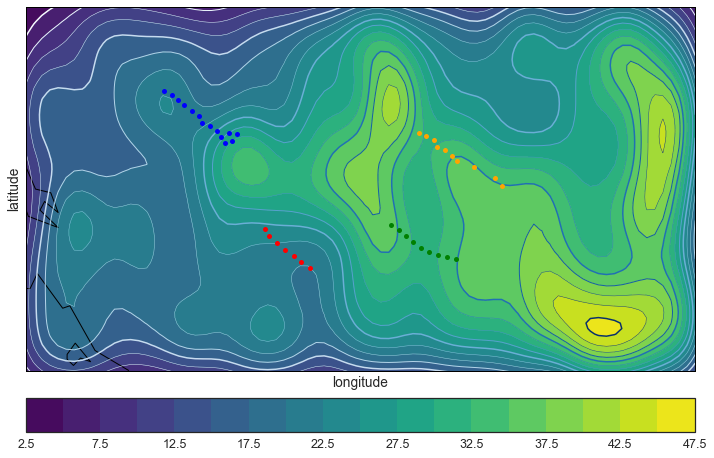

In [71]:
# Basemap plotting of KDE of lightning data lon-lat values
fig = plt.figure(figsize=(10, 8))
m = Basemap(projection='merc', ellps='WGS84', lat_0=43.5, lon_0=16, resolution='h', area_thresh=0.1,
            llcrnrlon=lon_cg.min(), llcrnrlat=lat_cg.min(), urcrnrlon=lon_cg.max(), urcrnrlat=lat_cg.max())
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
# Lightning density 
cs = m.contourf(lon, lat, data, 20, latlon=True, cmap=plt.cm.get_cmap('viridis'))
plt.colorbar(cs, orientation='horizontal', pad=0.05)
m.contour(lon, lat, data, 20, latlon=True, linewidths=[1.5, 1.0, 0.5, 0.5], 
          cmap=plt.cm.get_cmap('Blues'))
# Wind farm locations
for key, val in wind_farm_1.iteritems():
    m.plot(val[1], val[0], latlon=True, marker='o', markerfacecolor='green', markersize=5)
for key, val in wind_farm_2.iteritems():
    m.plot(val[1], val[0], latlon=True, marker='o', markerfacecolor='orange', markersize=5)
for key, val in wind_farm_3.iteritems():
    m.plot(val[1], val[0], latlon=True, marker='o', markerfacecolor='red', markersize=5)
for key, val in wind_farm_4.iteritems():
    m.plot(val[1], val[0], latlon=True, marker='o', markerfacecolor='blue', markersize=5)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.tight_layout()
plt.show()

In [17]:
colored_lgtn = colorize(data, cmap='viridis')
tileset = r'http://{s}.tile.thunderforest.com/cycle/{z}/{x}/{y}.png'  #Thunderforrest
attribution = '&copy; <a href="http://www.thunderforest.com/">Thunderforest</a>, '               '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a>'
mapa = folium.Map(location=[43.72, 16.05], zoom_start=12, tiles=tileset, attr=attribution)
ImageOverlay(np.flipud(colored_lgtn), bounds=[[43.6, 15.85], [43.8,  16.25]], opacity=0.5,
                            colormap=plt.cm.get_cmap('viridis'), mercator_project=True).add_to(mapa)
mapa

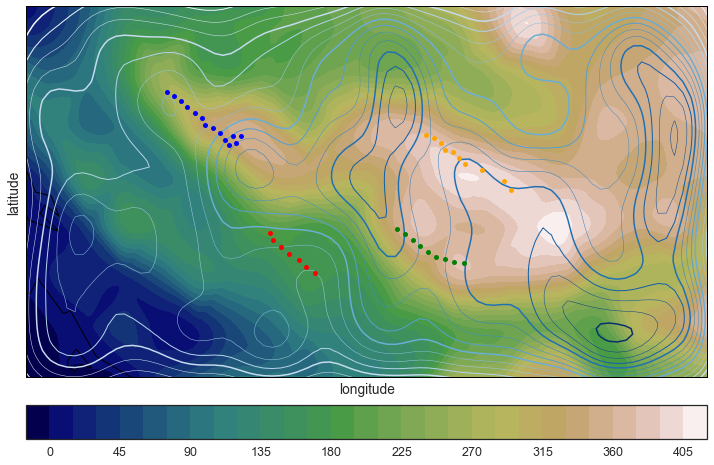

In [65]:
# Basemap *terrain & KDE* of lightning data lon-lat values
fig = plt.figure(figsize=(10, 8))
m = Basemap(projection='merc', ellps='WGS84', lat_0=43.5, lon_0=16, resolution='h', area_thresh=0.1,
            llcrnrlon=lon_cg.min(), llcrnrlat=lat_cg.min(), urcrnrlon=lon_cg.max(), urcrnrlat=lat_cg.max())
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
# Terrain
cs = m.contourf(XT, YT, ZT, 30, latlon=True, cmap=plt.cm.get_cmap('gist_earth'))
plt.colorbar(cs, orientation='horizontal', pad=0.05)
# Lightning density 
m.contour(lon, lat, data, 20, latlon=True, linewidths=[1.5, 1.0, 0.5, 0.5], 
          cmap=plt.cm.get_cmap('Blues'))
# Wind farm locations
for key, val in wind_farm_1.iteritems():
    m.plot(val[1], val[0], latlon=True, marker='o', markerfacecolor='green', markersize=5)
for key, val in wind_farm_2.iteritems():
    m.plot(val[1], val[0], latlon=True, marker='o', markerfacecolor='orange', markersize=5)
for key, val in wind_farm_3.iteritems():
    m.plot(val[1], val[0], latlon=True, marker='o', markerfacecolor='red', markersize=5)
for key, val in wind_farm_4.iteritems():
    m.plot(val[1], val[0], latlon=True, marker='o', markerfacecolor='blue', markersize=5)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.tight_layout()
plt.show()

### Lightning flash-cells identification

1 2014-09-01 02 342
3 2014-09-01 04 152
10 2014-09-01 11 328
11 2014-09-01 12 276


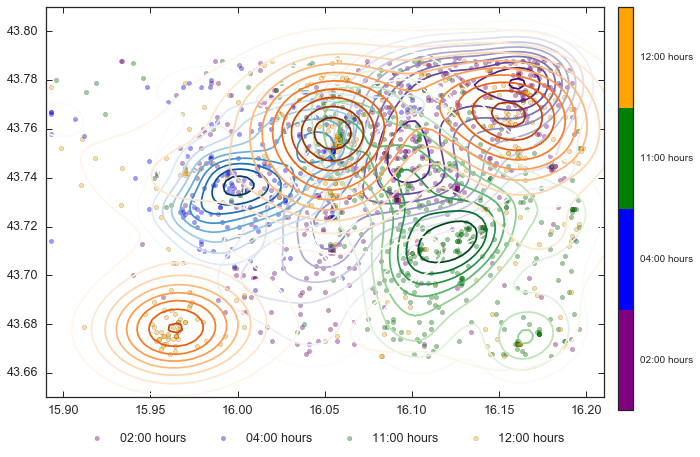

In [14]:
# Hourly tracking of thunderstorm development
times = []  # hours
positions = []  # hours integers
for k in range(len(time_frame)):
    # We need some number of strikes within the hour in order to proceed
    if cg_date['ampl'].ix[time_frame[k]].count() > 100:
        print(k, time_frame[k], cg_date['ampl'].ix[time_frame[k]].count())
        positions.append(k)
        times.append(time_frame[k])


from matplotlib.colors import ListedColormap
from matplotlib.colorbar import ColorbarBase

# There are four hours with intensive lightning activity
labels = [x[-2:]+':00 hours' for x in times]

colours = ['Purple', 'Blue', 'Green', 'Orange']
cmaps = ['Purples', 'Blues', 'Greens', 'Oranges']

# Display of thunderstorm development during the day
fig, ax = plt.subplots(figsize=(10, 7))
for k, t, col, c, lab in zip(positions, times, colours, cmaps, labels):
    lons_cg = cg_date['lon'].ix[time_frame[k]]
    lats_cg = cg_date['lat'].ix[time_frame[k]]
    lons_cc = cc_date['lon'].ix[time_frame[k]]
    lats_cc = cc_date['lat'].ix[time_frame[k]]
    # Aggregate CG and CC lightning
    lons = np.r_[lons_cg, lons_cc]
    lats = np.r_[lats_cg, lats_cc]
    sns.kdeplot(lons, lats, shade=False, shade_lowest=False, cmap=c, ax=ax)  # Seaborn kdeplot
    ax.scatter(lons, lats, s=20, c=col, label=lab, alpha=0.4)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=4, fancybox=True)  # legend
# Custom colormap
cmap = ListedColormap(colours)
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # colorbar axis
cbar = ColorbarBase(cax, cmap=cmap)
cbar.ax.get_yaxis().set_ticks([])
# Custom colorbar labels
for j, lab in enumerate(labels):
    cbar.ax.text(1.5, (2 * j + 1) / 8.0, lab, ha='left', va='center')
ax.set_xlim(15.89, 16.21)
ax.set_ylim(43.65, 43.81)
plt.show()

In [15]:
lons_cg = cg_date['lon'].ix[time_frame[positions[3]]]
lats_cg = cg_date['lat'].ix[time_frame[positions[3]]]
lons_cc = cc_date['lon'].ix[time_frame[positions[3]]]
lats_cc = cc_date['lat'].ix[time_frame[positions[3]]]
# Aggregate CG and CC lightning
lons = np.r_[lons_cg, lons_cc]
lats = np.r_[lats_cg, lats_cc]
X = np.c_[lons, lats]
lab = labels[3]

In [20]:
# Clustering algorithms from machine learning (scikit-learn)
cluster_method = 'mean-shift'
if cluster_method == 'mean-shift':
    # Compute clustering with MeanShift
    bw = estimate_bandwidth(X, quantile=0.3, n_jobs=-1)
    model = MeanShift(bandwidth=bw, min_bin_freq=10, bin_seeding=True)
    model.fit(X)
    cluster_centers = model.cluster_centers_
    labels = model.labels_
    labels_unique = np.unique(labels)
    n_clusters = len(labels_unique)   
elif cluster_method == 'k-means':
    # Compute clustering with KMeans
    model = KMeans(n_clusters=3)  # no. clusters as input
    model.fit(X)
    cluster_centers = model.cluster_centers_       
    labels = model.labels_
    labels_unique = np.unique(labels)
    n_clusters = len(labels_unique) 
elif cluster_method == 'k-means-mini':
    # Compute clustering with MiniBatchKMeans
    model = MiniBatchKMeans(n_clusters=3)  # no. clusters as input
    model.fit(X)
    cluster_centers = model.cluster_centers_       
    labels = model.labels_
    labels_unique = np.unique(labels)
    n_clusters = len(labels_unique)     
elif cluster_method == 'affinity':
    # Compute clustering using Affinity propagation
    model = AffinityPropagation(damping=0.9, preference=-50)
    model.fit(X)
    cluster_centers_indices = model.cluster_centers_indices_
    n_clusters = len(cluster_centers_indices)
    cluster_centers = model.cluster_centers_
    labels = model.labels_
print('Estimated number of clusters ({:s}): {:g}'.format(cluster_method, n_clusters))

# Silhouette Coefficient analysis
cluster_labels = model.fit_predict(X)
silhouette_avg = silhouette_score(X, cluster_labels)
print('The average Silhouette Coefficient is: {:.4f}'.format(silhouette_avg))

Estimated number of clusters (mean-shift): 3
The average Silhouette Coefficient is: 0.5764


In [14]:
# Finding optimal number of clusters using the silhouette analysis
# and Gaussian Mixture Models clustering algorithm (GaussianMixture)
nc = np.arange(2, 10, 1)
silhouette = []
for n in nc:
    # Gaussian Mixture Model
    model = GaussianMixture(n_components=n, covariance_type='full')
    model.fit(X)
    # Silhouette Coefficient analysis
    c_labels = model.predict(X)
    silh_avg = silhouette_score(X, c_labels)
    silhouette.append(silh_avg)
silhouette = np.asarray(silhouette)
print('Best Silhouette Coefficient is: {:.4f}'.format(silhouette.max()))
print('Optimal No. of clusters: {}'.format(nc[np.argmax(silhouette)]))

Best Silhouette Coefficient is: 0.5728
Optimal No. of clusters: 3


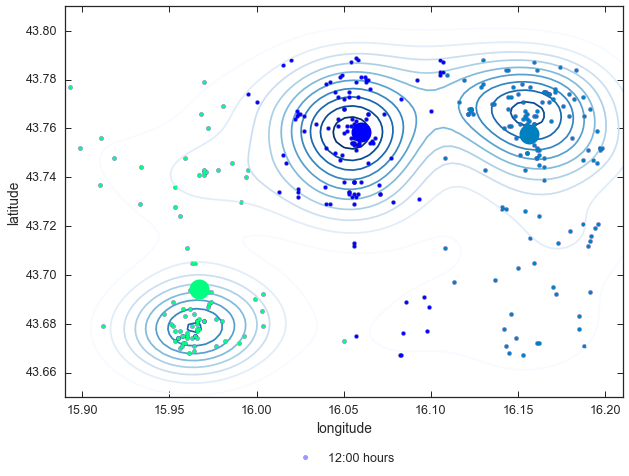

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.kdeplot(lons, lats, shade=False, shade_lowest=False, cmap=plt.cm.get_cmap('Blues'), ax=ax)       
ax.scatter(lons, lats, s=20, c='blue', label=lab, alpha=0.4)
colors = plt.cm.winter(np.linspace(0, 1, n_clusters))  # generate colours
if n_clusters > 0:
    for k, col in zip(range(n_clusters), colors):
        # Cluster centers
        cluster_center = cluster_centers[k]
        ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                markeredgecolor='black', markersize=20)
        # Cluster members
        members = (labels == k)
        ax.plot(X[members, 0], X[members, 1], '.', c=col)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=4, fancybox=True)  # legend
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_xlim(15.89, 16.21)
ax.set_ylim(43.65, 43.81)
plt.show()

Silhouette analysis can be used to study the separation distance between the resulting clusters. Silhoette coefficients are in the range of [-1, 1], where the values near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster. The thickness of the silhouette plot determines the cluster size. The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample, where a higher Silhouette Coefficient score relates to a model with better defined clusters. 

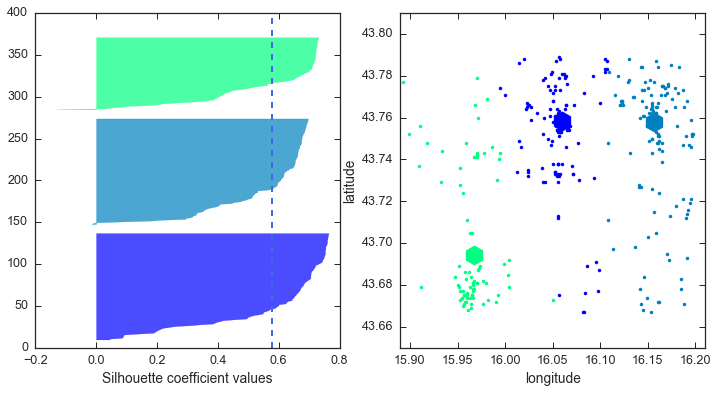

In [18]:
# Silhouette analysis of the number of clusters
from sklearn.metrics import silhouette_samples, silhouette_score
# http://scikit-learn.org/stable/auto_examples/
# cluster/plot_kmeans_silhouette_analysis.html
# #example-cluster-plot-kmeans-silhouette-analysis-py
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
colors = plt.cm.winter(np.linspace(0, 1, n_clusters))  # generate colours
if n_clusters > 0:
    y_lower = 10
    for k, col in zip(range(n_clusters), colors):
        silhouette_values = silhouette_samples(X, cluster_labels)
        # Aggregate the silhouette scores for samples belonging to
        # each cluster and sort them
        ith_cluster_silhouette_values = silhouette_values[cluster_labels == k]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=col, edgecolor=col, alpha=0.7)
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        # Cluster centers
        cluster_center = cluster_centers[k]
        ax2.plot(cluster_center[0], cluster_center[1], marker='h', markerfacecolor=col,
                markeredgecolor='black', markersize=20)
        # Cluster members
        members = (labels == k)
        ax2.plot(X[members, 0], X[members, 1], '.', c=col)
# The vertical line for average silhoutte score of all the values
ax1.axvline(x=silhouette_avg, color="royalblue", linestyle="--", lw=2)
ax1.set_xlabel("Silhouette coefficient values")
ax2.set_xlabel('longitude')
ax2.set_ylabel('latitude')
ax2.set_xlim(15.89, 16.21)
ax2.set_ylim(43.65, 43.81)
plt.show()

Additional methods for selectin the optimal number of clusters include: 
  - Calinski and Harabaz method
  - Gap statistic method
  - Distortion jump method
  - Bayes Information criterion
  - Akaike information criterion
  - etc.

Clustering algorithms introduced above will assign *every point* to some of the formed clusters, as can be seen from the figure above. At the same time, it is clear that some of the points are outliers to the formed clusters. It would be appreciated if these points could be removed and clusters formed only from tightly packed points. The distance metric can be used as a measure for detecting and removing these outliers. 

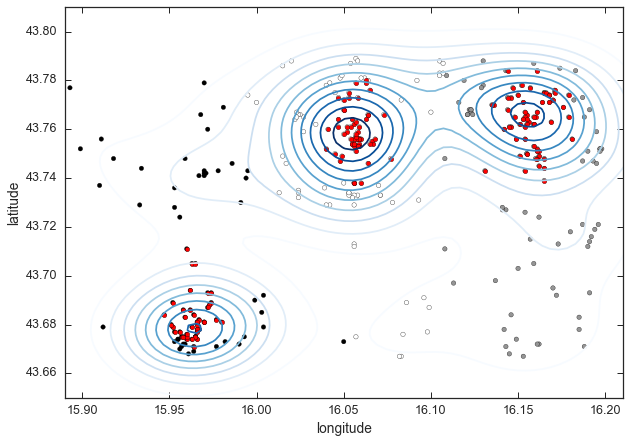

In [18]:
# Removing outlier data points from the clusters
# using quantile treshold and cluster centers
q = 50  # percentile of the euclidean distance distribution for treshold
fig, ax = plt.subplots(figsize=(10, 7))
sns.kdeplot(lons, lats, shade=False, shade_lowest=False, cmap=plt.cm.get_cmap('Blues'), ax=ax)
ax.scatter(X[:,0], X[:,1], s=20, c=labels)
# cluster labels = 0, 1, 2 for three clusters
for k in range(n_clusters):
    members = (labels == k)
    cc = cluster_centers[k]
    X_masked = X[members]
    # Points in cluster far away from the cluster center will be removed
    dist_eucl = pairwise.pairwise_distances(X_masked, cc.reshape(1,-1), metric='euclidean')
    # Treshold can be defined as the q-th percentile of the distance distribution
    treshold = np.percentile(dist_eucl, q)
    X_group = X_masked[np.where(dist_eucl<treshold)[0]]
    ax.scatter(X_group[:,0], X_group[:,1], s=20, c='red')  # red points retained
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_xlim(15.89, 16.21)
ax.set_ylim(43.65, 43.81)
plt.show()

Usually thunderstorms behave differently depending on the scale of analysis: individual cells generally move in several directions while the whole convective system moves in one preferred direction. Thus, using the hierarchical clustering, the tracking of convective systems may be carried out on different levels. Dendrogram can be used to estimate the optimal number of clusters in hierarchical clustering.

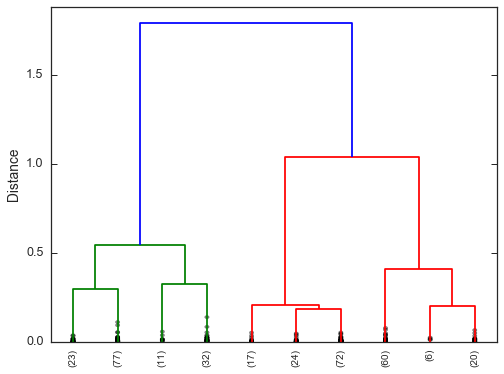

In [16]:
# Hierarchical clustering using Scipy
z_d = hierarchy.linkage(X, method='ward', metric='euclidean')
fig, ax = plt.subplots(figsize=(8, 6))
# Visualizing dendrogram
hierarchy.dendrogram(z_d, p=10, truncate_mode='lastp', leaf_rotation=90, 
                     leaf_font_size=10, show_contracted=True, ax=ax)
ax.set_ylabel('Distance')
plt.show()

In [18]:
# Define clusters from distance metric 
max_dist = 0.7  # from dendrogram
clusters = hierarchy.fcluster(z_d, max_dist, criterion='distance')
# No. of clusters
n_clusters = len(np.unique(clusters))
print('No. clusters: {:d}'.format(n_clusters))

No. clusters: 3


Estimated number of clusters (DBSCAN): 3


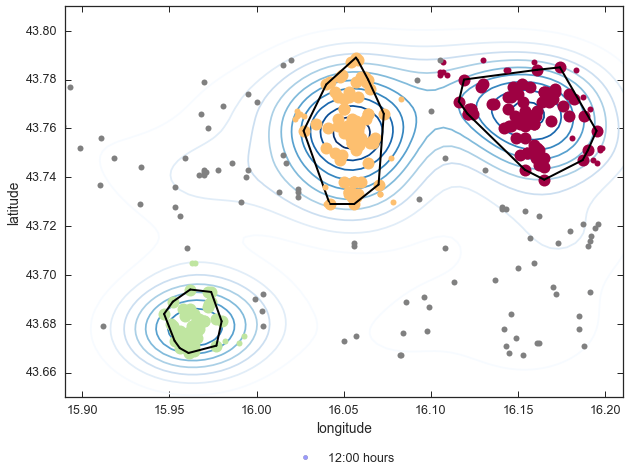

In [21]:
# Compute DBSCAN - Density-Based Spatial Clustering of Applications with Noise
# This algorithm does not assign all points to all clusters and does not need
# external outlier detection; it also does not need the number of clusters as
# input value (inputs are: eps and min_samples; see documentation on sklearn)
db = DBSCAN(eps=0.015, min_samples=10)
db.fit(X)
    
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters (DBSCAN): {:g}'.format(n_clusters_))

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(lons, lats, s=20, c='blue', label=lab, alpha=0.4)
sns.kdeplot(lons, lats, shade=False, shade_lowest=False, cmap=plt.cm.get_cmap('Blues'), ax=ax)
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))  # generate colours
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Grey used for noise.
        col = 'grey'
    class_member_mask = (labels == k)
    # Class members
    xy = X[class_member_mask & core_samples_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=12)
    
    # Flash-cell poligon can be created using convex hull with the cluster points
    # Convex hull is the smallest convex object containing all points in a given point set
    if k != -1:  # for clusters only
        cluster_points = xy
        hull = spatial.ConvexHull(xy)
        for simplex in hull.simplices:
            ax.plot(cluster_points[simplex,0], cluster_points[simplex,1], c='k', ls='-', lw=2)    
    # Not in the class
    xy = X[class_member_mask & ~core_samples_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=4, fancybox=True)  # legend
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_xlim(15.89, 16.21)
ax.set_ylim(43.65, 43.81)
plt.show()

### Lightning flash-cells movement tracking

Lightning activity recorded by LINET can be used for tracking (and even possibly predicting) the development and movement of thunderstorms. With direct access to the LINET servers this could be done in near real-time (large areas need to be monitored due to the extent of thunderstorms). It is based on recognizing the thunderstorm cells (from recorded CG and CC lightning activity) and their temporal evolution and movement. Here, a simple approach to the tracking of thunderstorm development during a single day is demonstrated for the date: 2014-09-01, using this dataset which covers a small surface area.

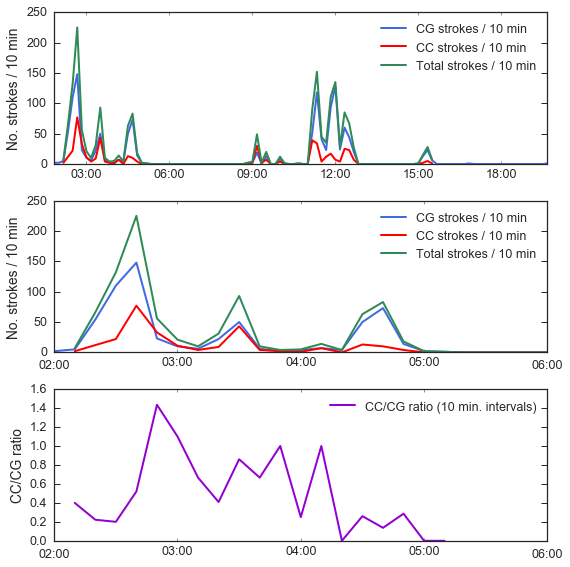

In [22]:
date = '2014-09-01'

# Number of strokes within 10 minute intervals for the day
cg_date = li.groupby('type').get_group(1)['ampl'].ix[date]
cc_date = li.groupby('type').get_group(2)['ampl'].ix[date]
cg_num = cg_date.resample('10min', how='count').fillna(0)
cc_num = cc_date.resample('10min', how='count').fillna(0)
total = cg_num + cc_num

fig, ax = plt.subplots(3, 1, figsize=(8, 8))
cg_num.plot(color='royalblue', ls='-', lw=2, label='CG strokes / 10 min', ax=ax[0])
cc_num.plot(color='red', ls='-', lw=2, label='CC strokes / 10 min', ax=ax[0])
total.plot(color='seagreen', ls='-', lw=2, label='Total strokes / 10 min', ax=ax[0])
ax[0].legend(loc='best')
ax[0].set_ylabel('No. strokes / 10 min')
# zoom-in on time frame
ts = '2014-09-01 02:00:00'
te = '2014-09-01 06:00:00'
cg_num.ix[ts:te].plot(color='royalblue', ls='-', lw=2, label='CG strokes / 10 min', ax=ax[1])
cc_num.ix[ts:te].plot(color='red', ls='-', lw=2, label='CC strokes / 10 min', ax=ax[1])
total.ix[ts:te].plot(color='seagreen', ls='-', lw=2, label='Total strokes / 10 min', ax=ax[1])
ax[1].legend(loc='best')
ax[1].set_ylabel('No. strokes / 10 min')
# CC/CG ratio within 10 minute intervals
cc_cg_ratio = cc_num.ix[ts:te] / cg_num.ix[ts:te]
cc_cg_ratio.plot(color='darkviolet', ls='-', lw=2, label='CC/CG ratio (10 min. intervals)', ax=ax[2])
ax[2].legend(loc='best')
ax[2].set_ylabel('CC/CG ratio')
plt.tight_layout()
plt.show()

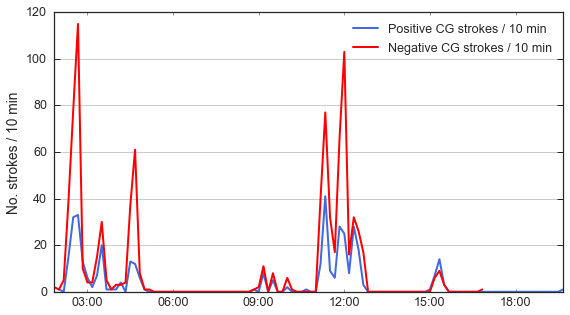

In [23]:
cg_poz_date = li.groupby(['type', 'pol']).get_group((1, 1))['ampl'].ix[date]
cg_poz_num = cg_poz_date.resample('10min', how='count').fillna(0)
cg_neg_date = li.groupby(['type', 'pol']).get_group((1, -1))['ampl'].ix[date]
cg_neg_num = cg_neg_date.resample('10min', how='count').fillna(0)

fig, ax = plt.subplots(figsize=(8,4.5))
cg_poz_num.plot(color='royalblue', ls='-', lw=2, label='Positive CG strokes / 10 min', ax=ax)
cg_neg_num.plot(color='red', ls='-', lw=2, label='Negative CG strokes / 10 min', ax=ax)
ax.legend(loc='best')
ax.set_ylabel('No. strokes / 10 min')
ax.grid(True)
plt.tight_layout()
plt.show()

In [24]:
cg_date = li.groupby('type').get_group(1).ix[date]
cc_date = li.groupby('type').get_group(2).ix[date]
time_frame = [date + ' ' + '0' + str(x) for x in range(1, 10)]
time_frame += [date + ' ' + str(x) for x in range(10, 20)]

# Hourly tracking of thunderstorm development
times = []  # hours
positions = []  # hours integers
for k in range(len(time_frame)):
    # We need some number of strikes within the hour in order to proceed
    if cg_date['ampl'].ix[time_frame[k]].count() > 100:
        print(k, time_frame[k], cg_date['ampl'].ix[time_frame[k]].count())
        positions.append(k)
        times.append(time_frame[k])

1 2014-09-01 02 342
3 2014-09-01 04 152
10 2014-09-01 11 328
11 2014-09-01 12 276


In [25]:
selection = time_frame[positions[0]]
lons_cg = cg_date['lon'].ix[selection]
lats_cg = cg_date['lat'].ix[selection]
lons_cc = cc_date['lon'].ix[selection]
lats_cc = cc_date['lat'].ix[selection]
# Aggregate CG and CC lightning
lons = np.r_[lons_cg, lons_cc]
lats = np.r_[lats_cg, lats_cc]
X = np.c_[lons, lats]

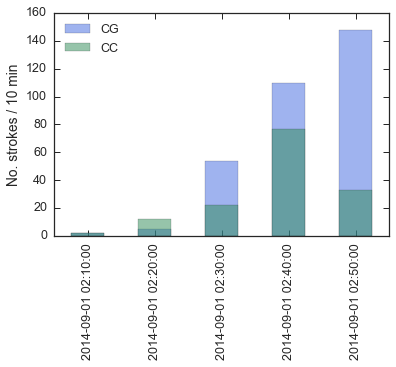

In [26]:
# CG lightning activity in 10 min. intervals
lons_cg.resample('10min', how='count').dropna().plot(kind='bar', color='royalblue', label='CG', alpha=0.5)
lons_cc.resample('10min', how='count').dropna().plot(kind='bar', color='seagreen', label='CC', alpha=0.5)
plt.legend(loc='best')
plt.ylabel('No. strokes / 10 min')
plt.show()

From the centers of clusters, as identified by the kernel density estimation and machine learning algorithm, the thunderstorm cells can be formed and temporal-evolution of their movement tracked. The method for cell tracking searches for event clusters and defines the border of a cell by means of the stroke density. A cell is suspected when the number of strokes per area surpasses a set minimum, and likewise the border is recognized when the absolute stroke number falls below this minimum. For each recognised cell area, a polygon can be drawn which serves to visually identify the thunderstorm cell.

No. cluster seeds: 1


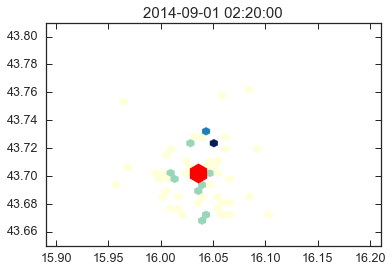

No. cluster seeds: 1


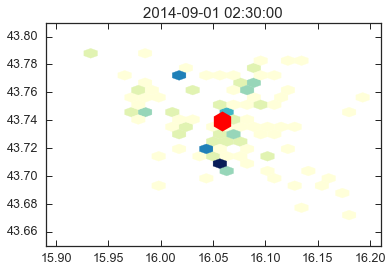

No. cluster seeds: 1


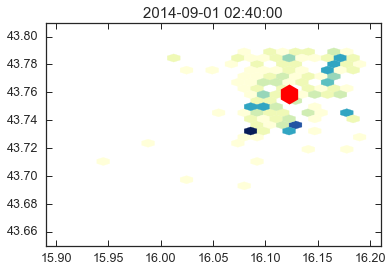

No. cluster seeds: 1


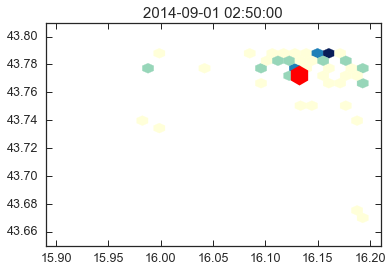

In [27]:
# Tracking thunderstorm movement using clustering algorithm
center_x = []
center_y = []
time_var = []
fraction = 0.9  # cluster seed selection criterion
show_cluster_members = False
mins = pd.date_range(start=selection, periods=7, freq='10min')  # one hour time window
for k in range(len(mins)-1):
    lons_ = lons_cg.ix[mins[k]:mins[k+1]]
    lats_ = lats_cg.ix[mins[k]:mins[k+1]]
    lons_ic = lons_cc.ix[mins[k]:mins[k+1]]
    lats_ic = lats_cc.ix[mins[k]:mins[k+1]]
    lons_all = np.r_[lons_, lons_ic]
    lats_all = np.r_[lats_, lats_ic]
    X = np.c_[lons_all, lats_all]
    if len(lons_all) > 10:  # need some data points
        hb = plt.hexbin(lons_all, lats_all, gridsize=20, mincnt=1, cmap=plt.cm.get_cmap('YlGnBu'))
        # Hexagons with highest lightning strike counts
        hexdata = hb.get_array()
        verts = hb.get_offsets()
        mask = np.where(hexdata > fraction*hexdata.max())
        vertices = verts[mask]
        no_cluster_seeds = vertices.shape[0]  
        print('No. cluster seeds: {}'.format(no_cluster_seeds))
        if no_cluster_seeds > 1:
            distances = pairwise.pairwise_distances(vertices)
            print(distances)
        
        # Compute clustering with KMeans
        model = KMeans(n_clusters=no_cluster_seeds)  
        model.fit(X)
        # Cluster centers
        cluster_centers = model.cluster_centers_  
        # Red hexagon indicates cluster center
        plt.plot(cluster_centers[0][0], cluster_centers[0][1], marker='h', 
                 markerfacecolor='red', markeredgecolor='black', markersize=20)
        center_x.append(cluster_centers[0][0])
        center_y.append(cluster_centers[0][1])
        time_var.append(mins[k])
        
        if show_cluster_members:
            unique_labels = set(model.labels_)
            colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))  # generate colours
            for k, col in zip(unique_labels, colors):
                class_member_mask = (model.labels_ == k)
                # Class members
                xy = X[class_member_mask]
                plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                        markeredgecolor='k', markersize=10)

        if no_cluster_seeds > 1:
            # Silhouette Coefficient analysis
            cluster_labels = model.fit_predict(X)
            silhouette_avg = silhouette_score(X, cluster_labels)
            print('The average Silhouette Coefficient is: {:.4f}'.format(silhouette_avg))

        plt.title(str(mins[k]))
        plt.xlim(15.89, 16.21)
        plt.ylim(43.65, 43.81)
        plt.show()

Estimated number of clusters (DBSCAN): 1


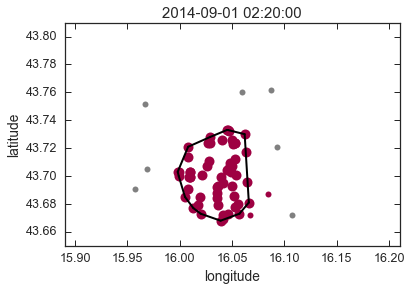

Estimated number of clusters (DBSCAN): 1


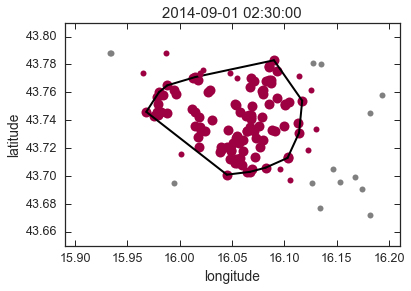

Estimated number of clusters (DBSCAN): 1


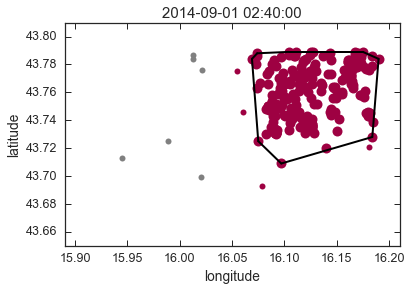

Estimated number of clusters (DBSCAN): 1


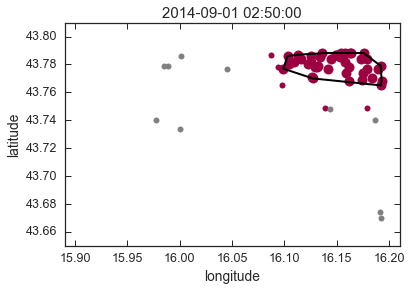

In [28]:
for k in range(len(mins)-1):
    lons_ = lons_cg.ix[mins[k]:mins[k+1]]
    lats_ = lats_cg.ix[mins[k]:mins[k+1]]
    lons_ic = lons_cc.ix[mins[k]:mins[k+1]]
    lats_ic = lats_cc.ix[mins[k]:mins[k+1]]
    lons_all = np.r_[lons_, lons_ic]
    lats_all = np.r_[lats_, lats_ic]
    X = np.c_[lons_all, lats_all]
    if len(lons_all) > 10:  # need some data points
        # Compute DBSCAN - Density-Based Spatial Clustering of Applications with Noise
        db = DBSCAN(eps=0.025, min_samples=10)  # tuning parameters <<<
        db.fit(X)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  # label -1 for noisy samples
        print('Estimated number of clusters (DBSCAN): {:g}'.format(n_clusters_))

        unique_labels = set(labels)
        colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))  # generate colours
        for ki, col in zip(unique_labels, colors):
            if ki == -1:
                # Grey used for noisy samples
                col = 'grey'
            class_member_mask = (labels == ki)
            # Class members
            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=10)
            
            # Flash-cell poligon can be created using convex hull with the cluster points
            # Convex hull is the smallest convex object containing all points in a given point set
            if ki != -1:  # for clusters only
                cluster_points = xy
                hull = spatial.ConvexHull(xy)

                # Pickle hull data
                with open('hulls_{:d}.p'.format(k), 'wb') as file_pointer:
                    pickle.dump(hull, file_pointer)
                # Draw a convex hull for each cluster
                for simplex in hull.simplices:
                    plt.plot(cluster_points[simplex,0], cluster_points[simplex,1], c='k', ls='-', lw=2)  
                    
            # Not in the class
            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                    markeredgecolor='k', markersize=6)

        plt.title(str(mins[k]))
        plt.xlim(15.89, 16.21)
        plt.ylim(43.65, 43.81)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.show()

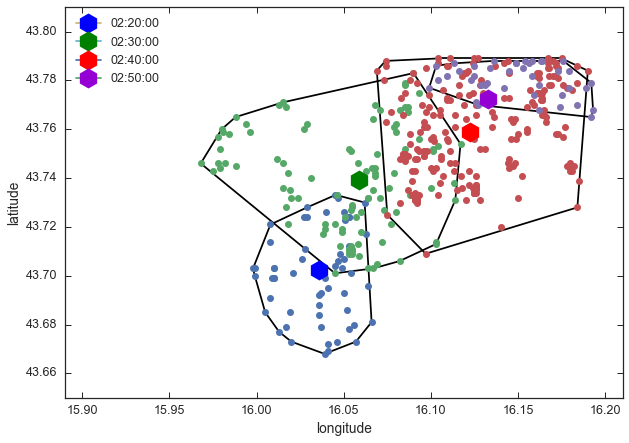

In [29]:
fig, ax = plt.subplots(figsize=(10,7))
# Convex hulls from flash-cell identification
hull_points = True
colors = ['blue', 'green', 'red', 'darkviolet']
for h, c in zip(np.arange(2, 6, 1), colors):
    with open('hulls_{:d}.p'.format(h), 'rb') as file_pointer:
        hull = pickle.load(file_pointer)
    if hull_points:
        # Show the convex hull with points
        spatial.convex_hull_plot_2d(hull, ax=ax)
    else:
        # Show the convex hull only
        for simplex in hull.simplices:
            ax.plot(hull.points[simplex,0], hull.points[simplex,1], color=c)
# Cluster centers from the KMeans algorithm
for x, y, t, c in zip(center_x, center_y, time_var, colors):
    ax.plot(x, y, marker='h', markerfacecolor=c, markeredgecolor='black', 
            markersize=20, label=str(t.time()))
ax.set_xlim(15.89, 16.21)
ax.set_ylim(43.65, 43.81)
ax.legend(loc='best')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

Convex hull, defined from cluster points, can be converted into the Polygon using the Shapely library. Then, that polygon data can be transformed (exported) into the GeoJson format and graphically presented on the Folium map. Shapely library can be used for all kinds of shape and polygon manipulations, including translation, analysis of shape overlappings, unions, and intersections. This can be usefull in identifying flash-cell **merge and split** conditions.

In [30]:
# Convex hulls on a folium map
color_dark = lambda feature: {'fillColor':'#1952E3', 'color':'#1952E3', 'fillOpacity':0.8}
color_medium = lambda feature: {'fillColor':'#5A83ED', 'color':'#5A83ED', 'fillOpacity':0.5}
color_light = lambda feature: {'fillColor':'#B6C8F7', 'color':'#B6C8F7', 'fillOpacity':0.5}
mapa = folium.Map(location=[43.75, 16.0], zoom_start=11)
with open('hulls_2.p', 'rb') as fp:
    hull = pickle.load(fp)
poly = geometry.Polygon(hull.points[hull.vertices])
geo_poly = geometry.mapping(poly)
# Translate (nowcasting)
dx = center_x[1] - center_x[0]
dy = center_y[1] - center_y[0]
trans_poly = affinity.translate(poly, dx, dy)
trans_geo = geometry.mapping(trans_poly)
t2_poly = affinity.translate(trans_poly, dx, dy)
t2_geo = geometry.mapping(t2_poly)

folium.GeoJson(t2_geo, style_function=color_light).add_to(mapa)
folium.GeoJson(trans_geo, style_function=color_medium).add_to(mapa)
folium.GeoJson(geo_poly, style_function=color_dark).add_to(mapa)
# Alarm zone (example)
mapa.circle_marker(location=[43.860372, 16.15526], radius=4000, popup='Drnis alarm zone',
                   line_color='red', fill_color='red')
mapa

In [31]:
# Convex hulls on a folium map
color_blue = lambda feature: {'fillColor':'royalblue', 'color':'royalblue', 'fillOpacity':0.5}
mapa = folium.Map(location=[43.75, 16.0], zoom_start=11)
for i, h in enumerate(np.arange(2, 6, 1)):
    with open('hulls_{:d}.p'.format(h), 'rb') as fp:
        hull = pickle.load(fp)
    poly = geometry.Polygon(hull.points[hull.vertices])
    geo_poly = geometry.mapping(poly)
    folium.GeoJson(geo_poly, style_function=color_blue).add_to(mapa)
# Track of thunderstorm movement
coordinates = zip(center_y, center_x)
folium.PolyLine(locations=coordinates, color='navy', weight=10, opacity=0.6).add_to(mapa)
# Alarm zone (example)

folium.CircleMarker(location=[43.860372, 16.15526], radius=4000, popup='Drnis alarm zone',
                    color='red', fill_color='red').add_to(mapa)
mapa

In [32]:
mapa = folium.Map(location=[43.75, 16.0], zoom_start=11)
with open('hulls_5.p', 'rb') as fp:
    hull = pickle.load(fp)
poly = geometry.Polygon(hull.points[hull.vertices])
geo_poly = geometry.mapping(poly)
# Translate (nowcasting)
dx = center_x[-1] - center_x[-2]
dy = center_y[-1] - center_y[-2]
trans_p1 = affinity.translate(poly, dx, dy)
trans_g1 = geometry.mapping(trans_p1)
trans_p2 = affinity.translate(trans_p1, dx, dy)
trans_g2 = geometry.mapping(trans_p2)
folium.GeoJson(trans_g2, style_function=color_light).add_to(mapa)
folium.GeoJson(trans_g1, style_function=color_medium).add_to(mapa)
folium.GeoJson(geo_poly, style_function=color_dark).add_to(mapa)
# Track of thunderstorm movement
folium.PolyLine(locations=coordinates, color='navy', weight=10, opacity=0.6).add_to(mapa)
# Alarm zone (example)
folium.CircleMarker(location=[43.860372, 16.15526], radius=4000, popup='Drnis alarm zone',
                    color='red', fill_color='red').add_to(mapa)
mapa

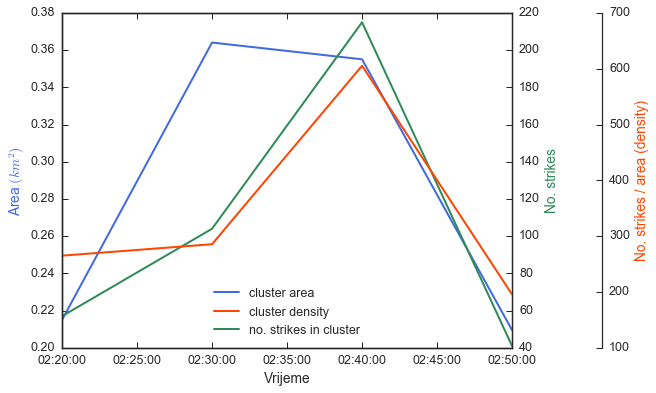

In [33]:
import matplotlib.dates as mdates

area = []
no_points = []
for h in np.arange(2, 6, 1):
    with open('hulls_{:d}.p'.format(h), 'rb') as file_pointer:
        hull = pickle.load(file_pointer)
        area.append(hull.area)
        no_points.append(hull.points.shape[0])

dens = [p/a for a, p in zip(area, no_points)]

fig, ax = plt.subplots(figsize=(10,6))
r_ax = ax.twinx()
r2_ax = ax.twinx()
fig.subplots_adjust(right=0.75)
r2_ax.spines['right'].set_position(('axes', 1.2))
l1 = ax.plot(time_var, area, c='royalblue', ls='-', lw=2, label='cluster area')
l2 = r2_ax.plot(time_var, dens, c='orangered', ls='-', lw=2, label='cluster density')
l3 = r_ax.plot(time_var, no_points, c='seagreen', ls='-', lw=2, label='no. strikes in cluster')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel('Area '+r'$(km^2)$', color='royalblue')
ax.set_xlabel('Vrijeme')
r2_ax.set_ylabel('No. strikes / area (density)', color='orangered')
r_ax.set_ylabel('No. strikes', color='seagreen')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='best')
plt.show()

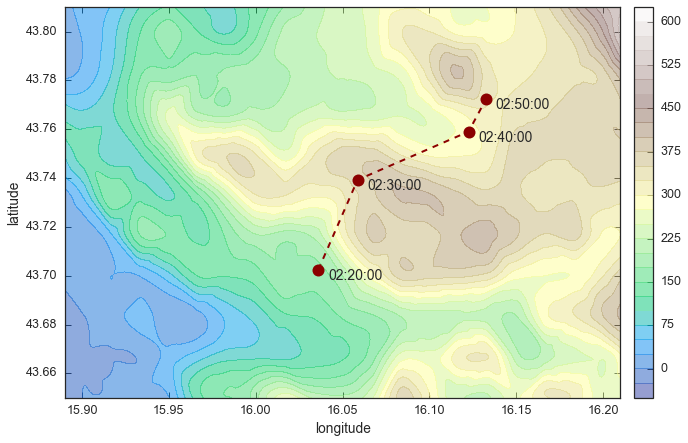

In [34]:
# Path of the flash-cell movement
fig, ax = plt.subplots(figsize=(12,7))
cs = ax.contourf(XT, YT, ZT, 30, cmap=plt.cm.get_cmap('terrain'), alpha=0.5)
plt.colorbar(cs, orientation='vertical', pad=0.02)
ax.plot(center_x, center_y, color='darkred', ls='--', lw=2, marker='o', markersize=12)
for t, x, y in zip(time_var, center_x, center_y):
    ax.annotate(str(t.time()), xy=(x, y), xycoords='data', 
                 xytext=(10, -10), textcoords='offset points', size=14)
ax.set_xlim(15.89, 16.21)
ax.set_ylim(43.65, 43.81)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

### Nowcasting

Using the Haversine distance between cluster centers and time interval (10 minutes) a speed of cluster movement can be determined for each successive time step. Using the Weighted Least Squares Analysis with several (three to four) time steps, a general direction of the cluster movement can be establised (including confidence and prediction levels). Weights are determined in such a manner as to favor the latest time instance possitions and cluster speeds. Nowcasting establishes probable location of the cluster center (after the next 10 minute interval) using the weighted average speed and weighted average angle of cluster center movement between succesive time instances.

In [49]:
delta = 10.  # 10 min. interval

# Great circle distance between points
def distance(lon_wt, lat_wt, lon_rad, lat_rad):
    # Compute a great circle distance between two points on the globe
    distance = 2.*np.arcsin(np.sqrt((np.sin((lat_wt-lat_rad)/2.))**2 +
                                    np.cos(lat_wt)*np.cos(lat_rad) *
                                    (np.sin((lon_wt-lon_rad)/2.))**2))
    return distance

# Angle (true course) between points
def true_angle(lon_wt, lat_wt, lon_rad, lat_rad):
    tc1 = np.mod(np.arctan2(np.sin(lon_wt-lon_rad)*np.cos(lat_rad),
                 np.cos(lat_wt)*np.sin(lat_rad)-np.sin(lat_wt) *
                 np.cos(lat_rad)*np.cos(lon_wt-lon_rad)), 2*np.pi)
    return tc1

v = []  # speed
d = []  # distance
alpha = []  # angle
# Geometrical space
geometry = 'haversine'
if geometry == 'euclid':
    # Euclidean geometry
    for i in range(len(time_var)-1):
        dist = np.sqrt((center_x[i]-center_x[i+1])**2 + (center_y[i]-center_y[i+1])**2)
        d.append(dist)
        v.append(dist/delta)
        angle = np.arctan2(abs(center_y[i]-center_y[i+1]),
                           abs(center_x[i]-center_x[i+1]))*180./np.pi
        alpha.append(angle)
elif geometry == 'haversine':
    # Spherical geometry (Haversine distance)
    for i in range(len(time_var)-1):
        dist = distance(center_x[i], center_y[i], center_x[i+1], center_y[i+1])
        d.append(dist)
        v.append(dist/delta)
        angle = true_angle(center_x[i], center_y[i], center_x[i+1], center_y[i+1])
        angle = angle*180./np.pi - 270.  # reference frame adjustment
        alpha.append(angle)

In [50]:
# weights (more recent time instances have larger weights)
w = np.arange(1, len(v)+1, 1)
w = w[::-1]  # invert order
w = 1./w

# average speed and distance covered (weighted)
v_m = np.average(v, weights=w)
v_std = np.sqrt(np.average((v-v_m)**2, weights=w))
d_m = v_m*delta  # distance from speed
d_mean = np.average(d, weights=w)
d_std = np.sqrt(np.average((d-d_mean)**2, weights=w))

# average angle (weighted)
a_mean = np.average(alpha, weights=w)
a_std = np.sqrt(np.average((alpha-a_mean)**2, weights=w))
a_min = a_mean - 2.*a_std  # 2 standard deviations
a_max = a_mean + 2.*a_std

#### Linear Regression using Weighted Least Squares (WLS) Analysis 

In [43]:
# Weights for the WLS analysis
w = np.arange(0, len(center_x)+1, 1)
w = w[::-1]  # invert order
weight = '1/x'
if weight == '1/x':
    w = 1./w
    w = w[:-1]
elif weight == '0.5**x':
    w = 0.5**w
    w = w[1:]
elif weight == 'exp':
    w = np.exp(-w)
    w = w[1:]

In [44]:
X = np.c_[np.ones(len(center_x)), center_x]
y = center_y
# Statsmodels Linear Regression using Weighted Least Squares (WLS) Analysis 
model_ols = sm.WLS(y, X, weights=w)    # notice the order of the endog and exog variables
res_ols = model_ols.fit()
res_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.907
Model:                            WLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     19.48
Date:                Thu, 16 Feb 2017   Prob (F-statistic):             0.0477
Time:                        14:04:44   Log-Likelihood:                 13.921
No. Observations:                   4   AIC:                            -23.84
Df Residuals:                       2   BIC:                            -25.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         34.2582      2.152     15.919      0.004        24.999    43.517
x1             0.5896      0.134      4.413      0.048         0.015     1.165
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.145
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.438
Skew:                           0.371   Prob(JB):                        0.803
Kurtosis:                       1.559   Cond. No.                     7.09e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
# New data for the prediction
support = np.linspace(16.0, 16.25, 50)
xnew = np.c_[np.ones(support.size), support]  # must be a 2D array
out_ols = res_ols.predict(xnew)

In [46]:
# Confidance intervals for WLS using bootstrap method
alpha = 0.05  # 95% confidence interval
n_boot = 1000  # No. of bootstrap samples

y_hat = res_ols.fittedvalues  # fittedvalues = np.dot(exog, params)
residuals = res_ols.resid  # residuals = endog - fittedvalues

values = []
# Bootstrap
for i in range(n_boot):
    resid_boot = np.random.choice(residuals, size=len(residuals), replace=True)
    yboot = y_hat + resid_boot
    model_boot = sm.OLS(yboot, X)
    res_boot = model_boot.fit()
    # Prediction values
    out_boot = res_boot.predict(xnew)
    values.append(out_boot)
values = np.asarray(values)

# Means and standard deviations of predicted values
means = np.mean(values, axis=0)
stds = np.std(values, axis=0)

ql = (alpha/2)*100.
qh = (1 - alpha/2)*100.
ci_lows = np.percentile(values, ql, axis=0, interpolation='midpoint')
ci_higs = np.percentile(values, qh, axis=0, interpolation='midpoint')

In [47]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Computing prediction intervals from WLS regression
prstd, iv_l, iv_u = wls_prediction_std(res_ols, exog=xnew, alpha=0.05)  # notice the exog parameter

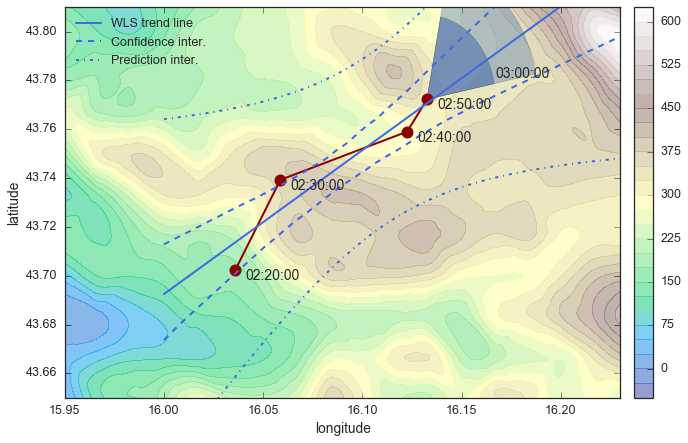

In [57]:
import matplotlib.patches as patches

# Nowcasting flash-cell position
future = time_var[-1] + dt.timedelta(minutes=10)

fig, ax = plt.subplots(figsize=(12,7))
cs = ax.contourf(XT, YT, ZT, 30, cmap=plt.cm.get_cmap('terrain'), alpha=0.5)
plt.colorbar(cs, orientation='vertical', pad=0.02)
ax.plot(center_x, center_y, color='darkred', ls='-', lw=2, marker='o', markersize=12)
for t, x, y in zip(time_var, center_x, center_y):
    ax.annotate(str(t.time()), xy=(x, y), xycoords='data', 
                 xytext=(10, -10), textcoords='offset points', size=14)
# Dark Wedge defines a probable area of finding the cluster center 
ax.add_patch(patches.Wedge((center_x[-1], center_y[-1]), d_mean, a_min, a_max, alpha=0.6))
# Light Wedge accounts for the weighted standard deviation of the prediction
ax.add_patch(patches.Wedge((center_x[-1], center_y[-1]), d_mean+d_std, a_min, a_max, alpha=0.4))
ax.annotate(future.time(), xy=(center_x[-1]+d_m, center_y[-1]+d_m/4), xycoords='data', 
            xytext=(0, 0), textcoords='offset points', size=14)
ax.plot(support, out_ols, c='royalblue', ls='-', lw=2, label='WLS trend line')
ax.plot(support, ci_lows, c='royalblue', ls='--', lw=2, label='Confidence inter.')
ax.plot(support, ci_higs, c='royalblue', ls='--', lw=2)
ax.plot(support, iv_l, c='royalblue', ls='-.', lw=2, label='Prediction inter.')
ax.plot(support, iv_u, c='royalblue', ls='-.', lw=2)
ax.legend(loc='best')
ax.set_xlim(15.95, 16.23)
ax.set_ylim(43.65, 43.81)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

#### Vector Autoregression (VAR) analysis

In [52]:
dataf = pd.DataFrame({'x':center_x, 'y':center_y}, index=time_var)
dataf

x          y
2014-09-01 02:20:00  16.036000  43.702424
2014-09-01 02:30:00  16.058621  43.739258
2014-09-01 02:40:00  16.122542  43.759036
2014-09-01 02:50:00  16.132500  43.772214

In [53]:
# Vector Autoregression Analysis (VAR) 
var_model = sm.tsa.VAR(dataf).fit(1)  # lag order

In [54]:
# Forecasting movement from the VAR model
forecast = var_model.forecast(dataf.values[:-1], 2)  # one step into future

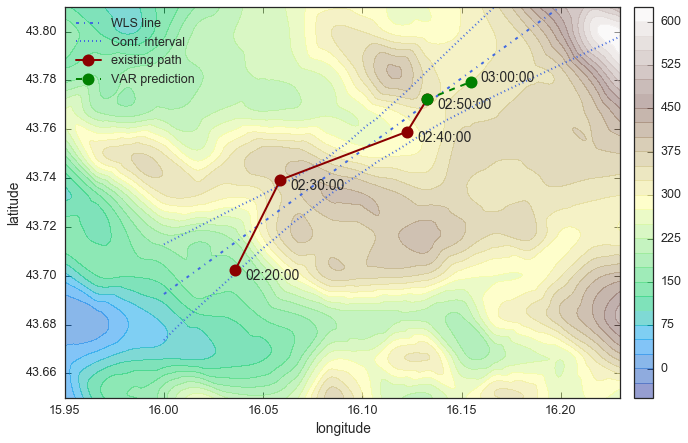

In [65]:
fig, ax = plt.subplots(figsize=(12,7))
cs = ax.contourf(XT, YT, ZT, 30, cmap=plt.cm.get_cmap('terrain'), alpha=0.5)
plt.colorbar(cs, orientation='vertical', pad=0.02)
# Weighted least squares
ax.plot(support, out_ols, c='royalblue', ls='-.', lw=2, label='WLS line')  # from WLS
ax.plot(support, ci_lows, c='royalblue', ls=':', lw=2, label='Conf. interval')   # from WLS
ax.plot(support, ci_higs, c='royalblue', ls=':', lw=2)  # from WLS
# Existing path
ax.plot(center_x, center_y, color='darkred', ls='-', lw=2, marker='o', 
        markersize=12, label='existing path')
for t, x, y in zip(time_var, center_x, center_y):
    ax.annotate(str(t.time()), xy=(x, y), xycoords='data', 
                 xytext=(10, -10), textcoords='offset points', size=14)
# AVR prediction
ax.plot(forecast[:,0], forecast[:,1], c='green', ls='--', lw=2, marker='o', 
        markersize=12, label='VAR prediction')
ax.annotate(future.time(), xy=(forecast[-1,0], forecast[-1,1]), xycoords='data', 
            xytext=(10, 0), textcoords='offset points', size=14)
ax.legend(loc='upper left', frameon=False)
ax.set_xlim(15.95, 16.23)
ax.set_ylim(43.65, 43.81)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

In [60]:
# Weighted combination of WLS and VAR model predictions
weight = 0.5
alpha = (a_min + a_max)/2.
lon_wls = center_x[-1] + d_mean*np.cos(alpha*np.pi/180.)
lat_wls = center_y[-1] + d_mean*np.sin(alpha*np.pi/180.)
wls = np.asarray([lon_wls, lat_wls])
print('WLS prediction:', wls)
var = forecast[-1]
print('VAR prediction:', var)
predicted = weight*wls + (1.-weight)*var
print('Weighted combination (w={:g}):'.format(weight), predicted)

WLS prediction: [ 16.15706181  43.79646777]
VAR prediction: [ 16.1544933   43.77938284]
Weighted combination (w=0.5): [ 16.15577755  43.78792531]
